###  Challenge 1 & 2

In [5]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [6]:
# Table Formatting

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [7]:
resp = requests.get('http://web.mta.info/developers/turnstile.html')
soup = BeautifulSoup(resp.text, 'lxml')

# read through html finding link tags
text_urls = []
for link in soup.findAll('a', href=re.compile(r'data/nyct/turnstile/turnstile_')):
    text_urls.append('http://web.mta.info/developers/'+link['href'])

# Only use from 2018
url_2018 = []
for u in text_urls:
    # Add all links from 2018 to a list
    if re.findall(r'turnstile_18', u):
        url_2018.append(u)
i = 1
for url in url_2018[:15]:
    if i == 1:
        df_import = pd.read_csv(str(url))
        print("Downloaded " + url + " from MTA website")
    else:
        df_import = df_import.append(pd.read_csv(str(url)))
        print("Downloaded " + url + " from MTA website")
    i += 1

# index gets repeated from each week - to be reset
df = df_import
df = df.reset_index()

Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180929.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180922.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180915.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180908.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180901.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180825.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180818.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180811.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180804.txt from MTA website
Downloaded http://web.mta.info/developers/data/nyct/turnstile/turnstile_180728.txt from MTA website


In [8]:
# Remove blank space from column names and convert to datetime
df.columns = [column.strip() for column in df.columns]
df['DATE_TIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'])
df['DATE'] = pd.to_datetime(df['DATE'])

In [9]:
df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,00:00:00,REGULAR,6767488,2294227,2018-09-22 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,04:00:00,REGULAR,6767499,2294230,2018-09-22 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,08:00:00,REGULAR,6767517,2294258,2018-09-22 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,12:00:00,REGULAR,6767607,2294323,2018-09-22 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,16:00:00,REGULAR,6767790,2294368,2018-09-22 16:00:00


### Challenge 3

In [134]:
def get_hourly_ENTRIES(df):
    # Subtract following hours entries to get amount within the hours
    hourly_entries = df.ENTRIES - df.ENTRIES.shift(1)
    df['ENTRIES_hr'] = hourly_entries.fillna(1)
    return df

def get_hourly_EXITS(df):
    hourly_exits = df.EXITS - df.EXITS.shift(1) 
    df['EXITS_hr'] = hourly_exits.fillna(1)
    return df

# Group by the three unique turnstile specifiers
df = df.groupby(['C/A', 'UNIT', 'SCP']).apply(get_hourly_ENTRIES)
df = get_hourly_EXITS(df)

In [35]:
df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,ENTRIES_hr,EXITS_hr
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,00:00:00,REGULAR,6767488,2294227,2018-09-22 00:00:00,1.0,1.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,04:00:00,REGULAR,6767499,2294230,2018-09-22 04:00:00,11.0,3.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,08:00:00,REGULAR,6767517,2294258,2018-09-22 08:00:00,18.0,28.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,12:00:00,REGULAR,6767607,2294323,2018-09-22 12:00:00,90.0,65.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,16:00:00,REGULAR,6767790,2294368,2018-09-22 16:00:00,183.0,45.0


In [44]:
# Remove the outliers from faulty equipment and keep the valid negatives
df = df.loc[(df.ENTRIES_hr<7000)&(df.ENTRIES_hr>-7000)]
df['ENTRIES_hr'] = df['ENTRIES_hr'].abs()

In [47]:
df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,ENTRIES_hr,EXITS_hr
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,00:00:00,REGULAR,6767488,2294227,2018-09-22 00:00:00,1.0,1.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,04:00:00,REGULAR,6767499,2294230,2018-09-22 04:00:00,11.0,3.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,08:00:00,REGULAR,6767517,2294258,2018-09-22 08:00:00,18.0,28.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,12:00:00,REGULAR,6767607,2294323,2018-09-22 12:00:00,90.0,65.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,16:00:00,REGULAR,6767790,2294368,2018-09-22 16:00:00,183.0,45.0


In [48]:
# Group for daily entries
df_day = (df
      .groupby(['C/A','UNIT','SCP', 'STATION', 'DATE'])['ENTRIES_hr']
      .sum()
      .reset_index()  
      .rename(columns = {'ENTRIES_hr':'ENTRIES_day'})
     )


In [49]:
df_day.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_day
0,A002,R051,02-00-00,59 ST,2018-06-16,556.0
1,A002,R051,02-00-00,59 ST,2018-06-17,592.0
2,A002,R051,02-00-00,59 ST,2018-06-18,1295.0
3,A002,R051,02-00-00,59 ST,2018-06-19,1409.0
4,A002,R051,02-00-00,59 ST,2018-06-20,1413.0


###  Challenge 4

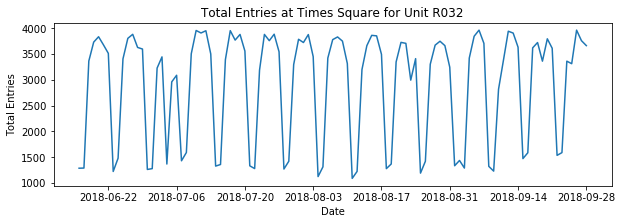

In [65]:
# Make a mask for specific turnstile
turnstile = ((df_day.SCP=='01-00-00') & (df_day.STATION=='TIMES SQ-42 ST') 
             & (df_day.UNIT==('R032')))

# Take dates and counts into list form to plot
dates = [x for x in df_day[turnstile]['DATE']]
counts = [y for y in df_day[turnstile]['ENTRIES_day']]

plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title('Total Entries at Times Square for Unit R032')
plt.xlabel('Date')
plt.ylabel('Total Entries')

###   Challenge 5

In [54]:
df_day_unit = (df_day
      .groupby(['C/A','UNIT', 'STATION', 'DATE'])['ENTRIES_day']
      .sum()
      .reset_index()
     )


In [55]:
df_day_unit.head()

,C/A,UNIT,STATION,DATE,ENTRIES_day
0,A002,R051,59 ST,2018-06-16,12225.0
1,A002,R051,59 ST,2018-06-17,5821.0
2,A002,R051,59 ST,2018-06-18,11959.0
3,A002,R051,59 ST,2018-06-19,13374.0
4,A002,R051,59 ST,2018-06-20,13851.0


### Challenge 6

In [56]:
df_day_station = (df_day_unit
      .groupby(['STATION', 'DATE'])['ENTRIES_day']
      .sum()
      .reset_index()
     )

In [57]:
df_day_station.head()

,STATION,DATE,ENTRIES_day
0,1 AV,2018-06-16,17680.0
1,1 AV,2018-06-17,14290.0
2,1 AV,2018-06-18,19705.0
3,1 AV,2018-06-19,19830.0
4,1 AV,2018-06-20,22019.0


### Challenge 7

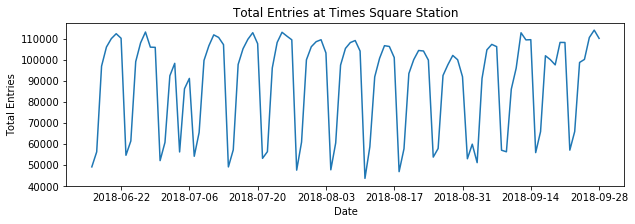

In [64]:
# Mask for time series of one station
station = (df_day_station.STATION == 'TIMES SQ-42 ST') 

dates = [x for x in df_day_station[station]['DATE']]
counts = [y for y in df_day_station[station]['ENTRIES_day']]

plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.title('Total Entries at Times Square Station')
plt.xlabel('Date')
plt.ylabel('Total Entries')

### Challenge 8

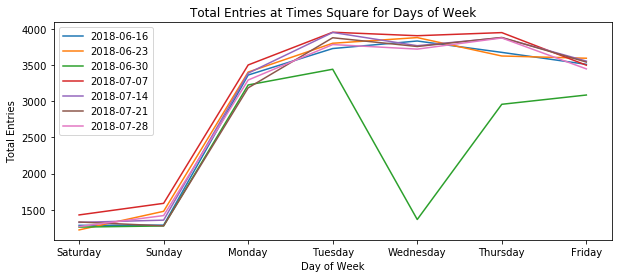

In [107]:
day_names = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Create plot figure
fig, ax = plt.subplots(figsize=(10,4))

# Add values to figure for 7 weeks separately 
for i in range(0,7):
    # plot x values from 0 to 6 for days and y values of counts indexed
    # from 0 to 7, 7 to 14, etc.
    ax.plot(list(range(0,7)), counts[i*7:(i+1)*7], label=dates[i*7].date())

plt.title('Total Entries at Times Square for Days of Week')
plt.xticks(range(7),day_names)
plt.xlabel('Day of Week')
plt.ylabel('Total Entries')
ax.legend()

The noticable drop on Wednesday happens to be July 4th.

### Challenge 9

In [117]:
df_total_station = (df_day_station
      .groupby(['STATION'])['ENTRIES_day']
      .sum()
      .reset_index()
      .rename(columns = {'ENTRIES_day':'ENTRIES_total'})
      .sort_values('ENTRIES_total', ascending=False)
     )

In [128]:
df_total_station.head()

,STATION,ENTRIES_total
61,34 ST-PENN STA,14664512.0
233,GRD CNTRL-42 ST,13141459.0
59,34 ST-HERALD SQ,11333643.0
226,FULTON ST,10102660.0
46,23 ST,9394113.0


### Challenge 10

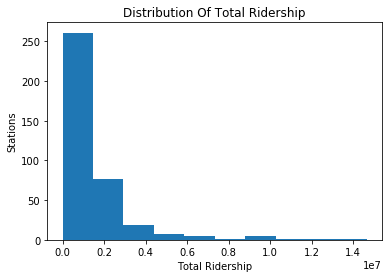

In [133]:
# format rider quantites to list for plotting
total_riders = [x for x in df_total_station['ENTRIES_total']]

plt.hist(total_riders)
plt.title('Distribution Of Total Ridership')
plt.xlabel('Total Ridership')
plt.ylabel('Stations')